In [5]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scipy as sp

In [26]:
import seaborn as sns

In [60]:
#Import data
df = pd.read_csv("Init_dataset.csv")
df.sort_values(by="Date")
df.set_index("Date",inplace = True)
df.index = pd.to_datetime(df.index)

In [61]:
df2 = df.drop(["VN30_Open", "Set100_Open"], axis =1)

In [62]:
df2.iloc[0]

VN30_Closeprice      1070.77
Set100_ClosePrice        NaN
Name: 2020-12-31 00:00:00, dtype: float64

In [63]:
df2.describe()

,VN30_Closeprice,Set100_ClosePrice
count,1252.000000,1180.000000
mean,817.427037,2241.249847
std,144.498112,248.033149
min,538.530000,1484.850000
25%,673.297500,2055.070000
50%,853.955000,2251.825000
75%,916.545000,2431.202500
max,1177.680000,2677.390000


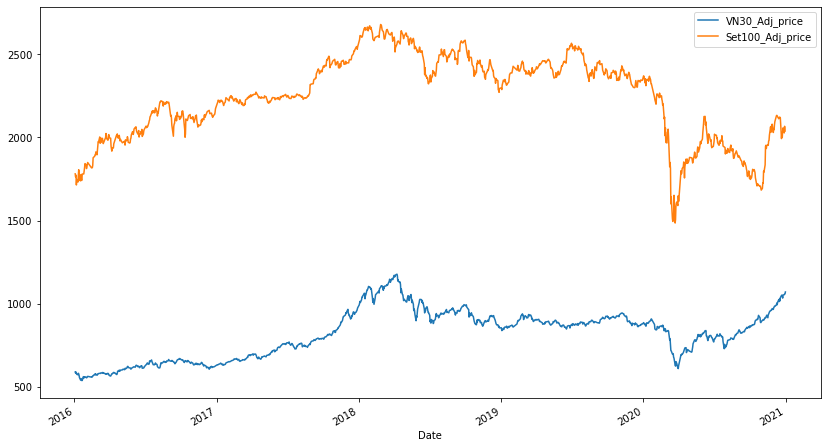

In [64]:
ax = df2['VN30_Closeprice'].dropna().plot(label='VN30_Adj_price')
df2.Set100_ClosePrice.dropna().plot(ax=ax, figsize = (14,8),kind='line' ,label='Set100_Adj_price')
plt.legend()
plt.show()

In [65]:
#Cal VN30/Set100
df2['VN/Set'] = df2['VN30_Closeprice'].values.ravel()/df['Set100_ClosePrice'].values.ravel()

In [66]:
df2

,VN30_Closeprice,Set100_ClosePrice,VN/Set
Date,,,
2020-12-31,1070.77,NaN,NaN
2020-12-30,1059.16,2037.03,0.519953
2020-12-29,1058.39,2066.08,0.512270
2020-12-28,1054.23,2026.21,0.520297
2020-12-25,1052.13,2056.64,0.511577
...,...,...,...
2016-01-08,575.96,1747.08,0.329670
2016-01-07,582.30,1713.68,0.339795
2016-01-06,589.97,1772.95,0.332762


In [71]:
#Cal EMA26, 12
df2['VNEMA26'] = df2.VN30_Closeprice.ewm(span = 26, adjust=False).mean() #spanday = 26
df2['Set100EMA26'] = df2.Set100_ClosePrice.ewm(span=26, adjust = False).mean()
df2['VNEMA12'] = df2.VN30_Closeprice.ewm(span=12, adjust=False).mean() #spanday = 12
df2['Set100EMA12'] = df2.Set100_ClosePrice.ewm(span=12, adjust=False).mean()

In [73]:
#MACD & Signal 9 == Convergence/Divergence Signal from MACD
df2['VN_MACD'] = df2.VNEMA12 - df2.VNEMA26 #Short-Long
df2['Set_MACD'] = df2.Set100EMA12 - df2.Set100EMA26

In [74]:
df2

,VN30_Closeprice,Set100_ClosePrice,VN/Set,VNEMA26,Set100EMA26,VNEMA12,Set100EMA12,VN_MACD,Set_MACD
Date,,,,,,,,,
2020-12-31,1070.77,NaN,NaN,1070.770000,NaN,1070.770000,NaN,0.000000,NaN
2020-12-30,1059.16,2037.03,0.519953,1069.910000,2037.030000,1068.983846,2037.030000,-0.926154,0.000000
2020-12-29,1058.39,2066.08,0.512270,1069.056667,2039.181852,1067.354024,2041.499231,-1.702643,2.317379
2020-12-28,1054.23,2026.21,0.520297,1067.958395,2038.220974,1065.334943,2039.147041,-2.623452,0.926067
2020-12-25,1052.13,2056.64,0.511577,1066.785921,2039.585346,1063.303413,2041.838266,-3.482508,2.252920
...,...,...,...,...,...,...,...,...,...
2016-01-08,575.96,1747.08,0.329670,564.003301,1801.424536,565.485719,1767.500665,1.482418,-33.923871
2016-01-07,582.30,1713.68,0.339795,565.358612,1794.924941,568.072531,1759.220562,2.713920,-35.704378
2016-01-06,589.97,1772.95,0.332762,567.181678,1793.297167,571.441373,1761.332784,4.259695,-31.964384


In [75]:
len(df2.index)

1252

In [93]:
#Signal Genr and MACD-Signal
signal_day = 9
k = 2/(signal_day+1) #Weight of alpha

#Gern Signal=9 of VN30
df2['VN_Signal'] = np.zeros(len(df2.index)) #Paste 0 into dataframe
df2['VN_Signal'].iloc[0] = df2.VN_MACD.iloc[0] #position[0] = MACD

for t in range(1,len(df2.VN_MACD)):
    df2['VN_Signal'].iloc[t] = (df2.VN_MACD.iloc[t]*k)+(df2.VN_MACD[t-1]*(1-k))
    
#Gern Signal=9 of Set100
df2['Set_Signal']=np.zeros(len(df2.index))
df2['Set_Signal'].iloc[1] = df2.VN_MACD.iloc[1] #Zero is Nan

for t in range(2,len(df2.VN_MACD)):
    df2['Set_Signal'].iloc[t] = (df2.Set_MACD.iloc[t]*k)+(df2.Set_MACD[t-1]*(1-k))

In [94]:
df2

,VN30_Closeprice,Set100_ClosePrice,VN/Set,VNEMA26,Set100EMA26,VNEMA12,Set100EMA12,VN_MACD,Set_MACD,VN_Signal,Set_Signal
Date,,,,,,,,,,,
2020-12-31,1070.77,NaN,NaN,1070.770000,NaN,1070.770000,NaN,0.000000,NaN,0.000000,0.000000
2020-12-30,1059.16,2037.03,0.519953,1069.910000,2037.030000,1068.983846,2037.030000,-0.926154,0.000000,-0.185231,-0.926154
2020-12-29,1058.39,2066.08,0.512270,1069.056667,2039.181852,1067.354024,2041.499231,-1.702643,2.317379,-1.081452,0.463476
2020-12-28,1054.23,2026.21,0.520297,1067.958395,2038.220974,1065.334943,2039.147041,-2.623452,0.926067,-1.886805,2.039117
2020-12-25,1052.13,2056.64,0.511577,1066.785921,2039.585346,1063.303413,2041.838266,-3.482508,2.252920,-2.795263,1.191438
...,...,...,...,...,...,...,...,...,...,...,...
2016-01-08,575.96,1747.08,0.329670,564.003301,1801.424536,565.485719,1767.500665,1.482418,-33.923871,0.724115,-34.431643
2016-01-07,582.30,1713.68,0.339795,565.358612,1794.924941,568.072531,1759.220562,2.713920,-35.704378,1.728718,-34.279973
2016-01-06,589.97,1772.95,0.332762,567.181678,1793.297167,571.441373,1761.332784,4.259695,-31.964384,3.023075,-34.956379


In [ ]:
df2['VN_MACD-Signal'] = 